# MFCC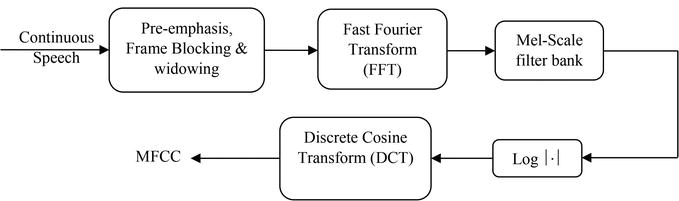

In [ ]:
! pip install -q librosa

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import numpy as np
import IPython.display as ipd
from scipy.io import wavfile

import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

# matplotlib inline

## Load audio file

In [3]:
#audio_data = '/content/drive/MyDrive/Colab Notebooks/Lecture_Librosa_Imarticus/audio-data/6ab74e177aa149468a39ca10beed6222.mp3'
#audio_data = '/content/drive/MyDrive/Colab Notebooks/Lecture_Librosa_Imarticus/audio-data/07ab324c602e4afab65ddbcc746c31b5.mp3'
#audio_data = '/content/drive/MyDrive/Colab Notebooks/Lecture_Librosa_Imarticus/audio-data/Normal_mrin_kok.wav'
#audio_data = '/content/drive/MyDrive/Colab Notebooks/Lecture_Librosa_Imarticus/audio-data/NormalSpeech_Spk18_Spk18_s16_2.wav'
audio_data = '/content/drive/MyDrive/Colab_Notebooks/Lecture_Librosa_Imarticus/TIMIT_Audio/sa1.wav'

'''
x: Speech Signal (one-dimensional array )
sr : Sampling rate
'''

x, sr = librosa.load(audio_data, sr = 16000, mono=True)

print(type(x), type(sr))
print('Speech signal shape: ',x.shape,'\n','Sampling Rate: ',sr)

<class 'numpy.ndarray'> <class 'int'>
Speech signal shape:  (58983,) 
 Sampling Rate:  16000


In [4]:
# Output the parameters: Signal Data Type, Sampling Frequency and Duration
print('\nShape of Signal:', x.shape)
print('Signal Datatype:', x.dtype)
print('Signal duration:', round(x.shape[0] / float(sr), 2), 'seconds')


Shape of Signal: (58983,)
Signal Datatype: float32
Signal duration: 3.69 seconds


## Time-domain audio signal. 
It shows the intensity (loudness or amplitude) of the sound wave with respect to time. Portions with amplitude = 0, represent silence.

In [ ]:
print('mean of speech before mean removal:', np.mean(x))

mean of speech before mean removal: 8.356299e-05


In [ ]:
print('mean of speech after mean removal:', np.mean(x-np.mean(x)))

mean of speech after mean removal: 2.84883e-11


Text(0.5, 0, 'time (sec)')

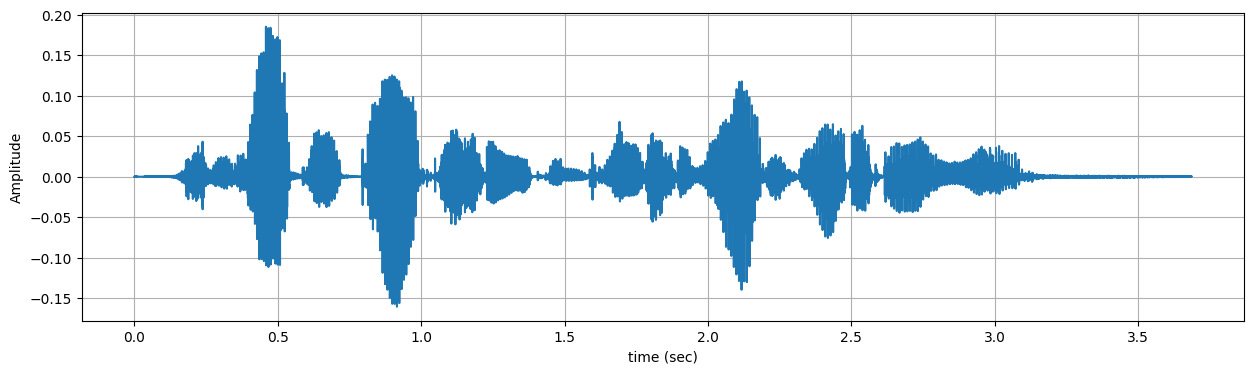

In [5]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(x) / sr, num=len(x)), x)
plt.grid(True)
plt.ylabel('Amplitude')
plt.xlabel('time (sec)')

In [ ]:
def normalize_audio(audio):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return audio

Text(0.5, 0, 'time (sec)')

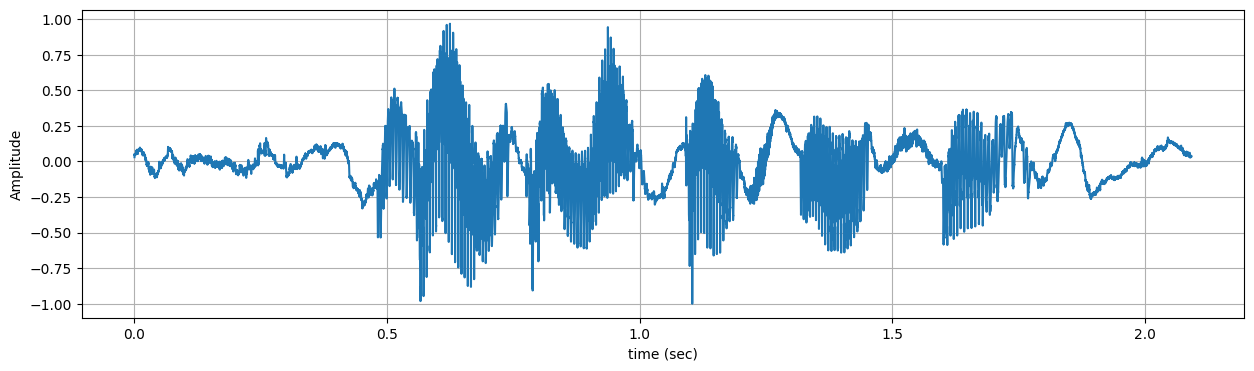

In [ ]:
# Normalize the Signal Value and Plot it on a graph
import matplotlib.pyplot as plt
x = normalize_audio(x)

plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(x) / sr, num=len(x)), x)
plt.grid(True)
plt.ylabel('Amplitude')
plt.xlabel('time (sec)')


#time_axis = 1000 * np.arange(0, len(x), 1) / float(sr)
#plt.plot(time_axis, x, color='blue')

## Remove low varying signal using High pass filter

In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.

T = round(x.shape[0] / float(sr), 2)        # Sample Period
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = np.multiply(0.5, sr)  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(np.multiply(T, sr)) # total number of samples

In [ ]:
def butter_highpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filter the data, and plot both the original and filtered signals.
y = butter_highpass_filter(x, cutoff, sr, order)
print(len(y), len(x))

time_axis = 1000 * np.arange(0, len(x), 1) / float(sr)
plt.plot(time_axis, y, color='blue')

#audio = normalize_audio(x)
#plt.figure(figsize=(15,4))
#plt.plot(np.linspace(0, len(x) / sr, num=len(x)), x)
plt.grid(True)

33476 33476


# Audio Framing
Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [ ]:
def frame_audio(audio, Frame_size=2048, hop_size=10, sample_rate=sr):
    # hop_size in ms
    
    audio = np.pad(audio, int(Frame_size / 2), mode='reflect')
    hop_len = np.round(sample_rate * hop_size / 1000).astype(int) # to convert ms into num of samples 
    frame_num = int((len(audio) - Frame_size) / hop_len) + 1
    frames = np.zeros((frame_num,Frame_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*hop_len:n*hop_len+Frame_size]
    
    return frames

In [ ]:
hop_size = 10 #ms
Frame_size = 2048

audio_framed = frame_audio(x, Frame_size=Frame_size, hop_size=hop_size, sample_rate=sr)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (210, 2048)


In [ ]:
print("First frame:")
audio_framed[1]

First frame:


array([-0.01393513, -0.01493856, -0.01533783, ...,  0.07021931,
        0.06670306,  0.06780548])

## Convert to frequency domain
Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window. [7]

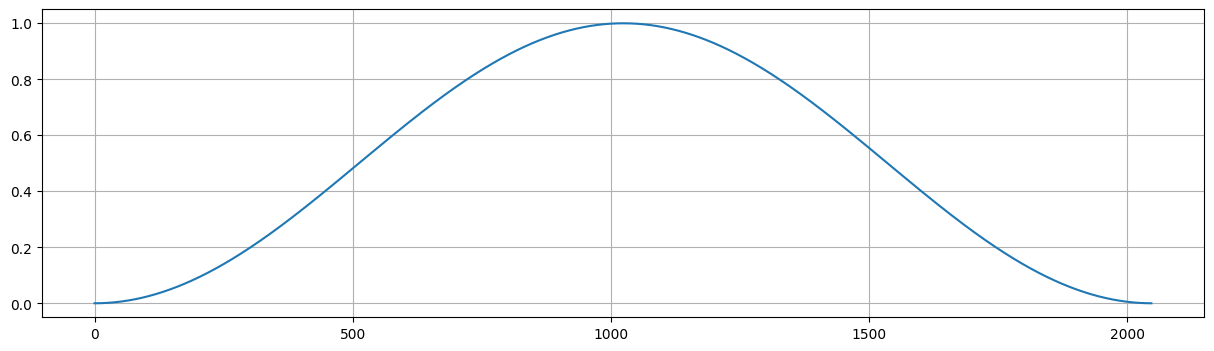

In [ ]:
from scipy.signal import get_window
window = get_window("hann", Frame_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

In [ ]:
audio_win = audio_framed * window

ind = 50
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In the plot above you can see the that both ends of the frame end on different places on the y axis. You can see that the window brought the edges of each frame closer to zero.

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).

In [ ]:
import scipy.fftpack as fft

audio_winT = np.transpose(audio_win) # frame size X num frames

audio_fft = np.empty((int(1 + Frame_size / 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

print('shape of audio_fft:', np.shape(audio_fft))
print('audio_fft:', audio_fft[0,1])

shape of audio_fft: (210, 1025)
audio_fft: (-38.8534+8.430756e-16j)


##Calculate signal power

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)
print('audio_fft:', audio_power[0,1])

(210, 1025)
audio_fft: 1509.5868


#MEL-spaced filterbank

Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [ ]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 26

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


## Compute filter points

First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.



In [ ]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [ ]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=sr):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [ ]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, Frame_size, sample_rate=sr)
filter_points
print('mel_freqs', mel_freqs)

MEL min: 0.0
MEL max: 2840.023046708319
mel_freqs [   0.           68.47927399  143.6577065   226.19065969  316.79760819
  416.26841104  525.47019727  645.35492499  776.96768002  921.45578634
 1080.07880785 1254.21952842 1445.3960063  1655.27480762 1885.68553457
 2138.63677481 2416.33361116 2721.1968443  3055.88409582 3423.3129759
 3826.68651734 4269.52109773 4755.67709321 5289.39253099 5875.32003406
 6518.56738    7224.74202773 8000.        ]


# Construct the filterbank


In [ ]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [ ]:
filters = get_filters(filter_points, Frame_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

# Filter the signal

In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(26, 210)

# Generate the Cepstral Coefficents
The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal.

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [ ]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 210)

# Reviewing Cepstral coefficents

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(x) / sr, num=len(x)), x)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

## Step 2: Frequency-Domain Representation
To better understand an audio signal, it is necessary to look at it through a frequency domain. This representation of an audio signal will give us details about the presence of different frequencies in the signal. Fourier Transform is a mathematical concept that can be used in the conversion of a continuous signal from its original time-domain state to a frequency-domain state. We will be using Fourier Transforms (FT) in Python to convert audio signals to a frequency-centric representation.



## Fourier Transforms in Python
Fourier Transforms is a mathematical concept that can decompose this signal and bring out the individual frequencies. This is vital for understanding all the frequencies that are combined together to form the sound we hear. Fourier Transform (FT) gives all the frequencies present in the signal and also shows the magnitude of each frequency.


All audio signals are composed of a collection of many single-frequency sound waves that travel together and create a disturbance in the medium of movement, for instance, a room. Capturing sound is essentially the capturing of the amplitudes that these waves generated in space.




## NumPy (np.fft.fft)
This NumPy function allows us to compute a 1-D discrete Fourier Transform. The function uses Fast Fourier Transform (FFT) algorithm to convert a given sequence to a Discrete Fourier Transform (DFT). In the file we are processing, we have a sequence of amplitudes drawn from an audio file, that were originally sampled from a continuous signal. We will use this function to covert this time-domain to a discrete frequency-domain signal.

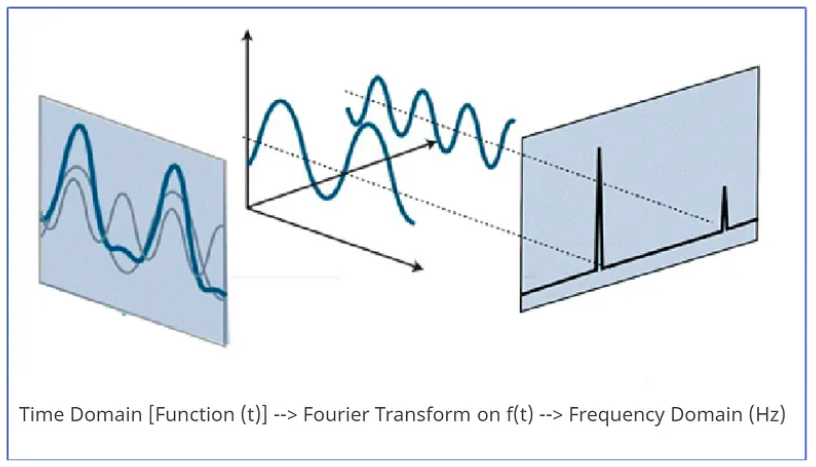



Content Credit: https://towardsdatascience.com/a-step-by-step-guide-to-speech-recognition-and-audio-signal-processing-in-python-136e37236c24


## Implement Fourier Transform to Audio signals with the aim of representing sound to its intensity (decibels (dB)).

<ipython-input-30-eb7f966219d3>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_length = np.ceil((sig_length + 1) / 2.0).astype(np.int)


Text(0.5, 0, 'Frequency (kHz)')

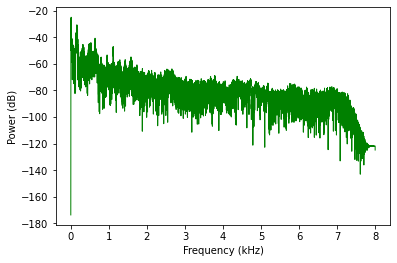

In [ ]:
# Working on the same input file

# Extracting the length and the half-length of the signal to input to the foruier transform
sig_length = len(x)
half_length = np.ceil((sig_length + 1) / 2.0).astype(np.int)

# We will now be using the Fourier Transform to form the frequency domain of the signal
signal_freq = np.fft.fft(x)

# Normalize the frequency domain and square it
signal_freq = abs(signal_freq[0:half_length]) / sig_length
signal_freq **= 2
transform_len = len(signal_freq)

# The Fourier transformed signal now needs to be adjusted for both even and odd cases
if sig_length % 2:
  signal_freq[1:transform_len] *= 2
else:
  signal_freq[1:transform_len-1] *= 2

# Extract the signal's strength in decibels (dB)
exp_signal = 10 * np.log10(signal_freq)
x_axis = np.arange(0, half_length, 1) * (sr / sig_length) / 1000.0
plt.plot(x_axis, exp_signal, color='green', linewidth=1)
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (kHz)')

# Step 3: Extracting Features from Speech

Once the speech is moved from a time-domain signal to a frequency domain signal, the next step is to convert this frequency domain data into a MFCC feature vector. 

## Mel Frequency Cepstral Coefficients (MFCCs)
MFCC is a technique designed to extract features from an audio signal. It uses the MEL scale to divide the audio signal’s frequency bands and then extracts coefficients from each individual frequency band, thus, creating a separation between frequencies. MFCC uses the Discrete Cosine Transform (DCT) to perform this operation. The MEL scale is established on the human perception of sound, i.e., how the human brain process audio signals and differentiates between the varied frequencies. Let us look at the formation of the MEL scale below.

## Human voice sound perception
An adult human, has a fundamental hearing capacity that ranges from 85 Hz to 255 Hz, and this can further be distinguished between genders (85Hz to 180 Hz for Male and 165 Hz to 255 Hz for females). 

Above these fundamental frequencies, there also are harmonics that the human ear processes. Harmonics are multiplications of the fundamental frequency. These are simple multipliers, for instance, a 100 Hz frequency’s second harmonic will be 200 Hz, third would be 300 Hz, and so on.

The rough hearing range for humans is 20Hz to 20KHz and this sound perception is also non-linear. We can distinguish low-frequency sounds better in comparison to high-frequency sounds. For example, we can clearly state the difference between signals of 100Hz and 200Hz but cannot distinguish between 15000 Hz and 15100 Hz. 


##MEL Scale 
It is a pitch scale (scale of audio signals with varying pitch levels) that is judged by humans on the basis of equality in their distances. It is basically a scale that is derived from human perception. 

For example, if you were exposed to two sound sources distant from each other, the brain will perceive a distance between these sources without actually seeing them. This scale is based on how we humans measure audio signal distances with the sense of hearing. Because our perception is non-linear, the distances on this scale increase with frequency.


In [ ]:
tone1 = librosa.tone(500, sr=sr, duration=1)
ipd.Audio(tone1,rate=sr, autoplay=True)

In [ ]:
tone2 = librosa.tone(620, sr=sr, duration = 1)
ipd.Audio(tone2,rate=sr, autoplay=True)

## MEL-spaced Filterbank 

To compute the power (strength) of every frequency band, the first step is to distinguish the different feature bands available (done by MFCC). Once these segregations are made, we use filter banks to create partitions in the frequencies and separate them. Filter banks can be created using any specified frequency for partitions. The spacing between filters within a filter bank grows exponentially as the frequency grows. In the code section, we will see how to separate frequency bands.

In [ ]:
# Installing and importing necessary libraries
! pip install -q python_speech_features
#pip install python_speech_features

  Preparing metadata (setup.py) ... done



MFCC Parameters
Window Count = 208
Individual Feature Length = 13


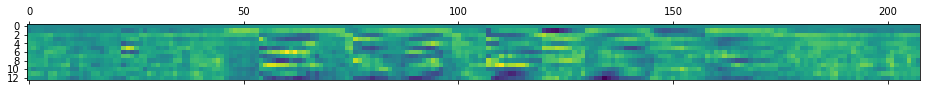

In [ ]:
from python_speech_features import mfcc, logfbank

#sampling_freq, sig_audio = wavfile.read("Welcome.wav")
## We will now be taking the first 15000 samples from the signal for analysis
#sig_audio = sig_audio[:15000]

# Using MFCC to extract features from the signal
mfcc_feat = mfcc(x, sr)
print('\nMFCC Parameters\nWindow Count =', mfcc_feat.shape[0])
print('Individual Feature Length =', mfcc_feat.shape[1])

mfcc_feat = mfcc_feat.T
plt.matshow(mfcc_feat)


## Generating filter bank features


Filter bank
Window Count = 208
Individual Feature Length = 26


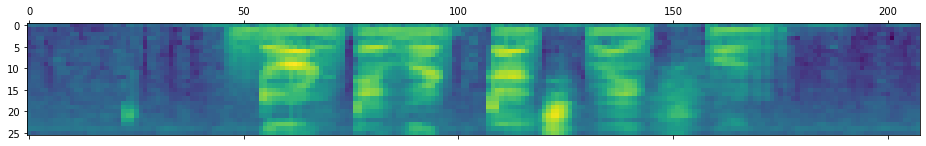

In [ ]:
# Log Filterbank Energies
fb_feat = logfbank(x, sr)
print('\nFilter bank\nWindow Count =', fb_feat.shape[0])
print('Individual Feature Length =', fb_feat.shape[1])
fb_feat = fb_feat.T
plt.matshow(fb_feat)